This is a notebook that analyzes the files created to describe the dataset before the quality control step.

Before this analysis, the files were filtered to remove extreme outliers. Individuals and variants with missingess >= 10% were removed.

The files were created using commands:

1. Data description -> General distribution of depth, missingness, heterozygosity (.vchk file output)
bcftools stats joint.hg38.vcf.gz > joint.hg38.vchk

2. Generate a summary of the number of SNPs and Ts/Tv ratio for each FILTER category. (.FILTER.summary file output)
vcftools --gzvcf joint.hg38.vcf.gz --FILTER-summary --out joint.hg38.PRE-QC
 
3. Site missingness -> Generate a file reporting the missingness on a per-site basis. (.lmiss file output)
vcftools --gzvcf joint.hg38.vcf.gz --missing-site --out joint.hg38.PRE-QC

4. Individual missingness -> Generate a file reporting the missingness on a per-individual basis.(.imiss file output)
vcftools --gzvcf joint.hg38.vcf.gz --missing-indv --out joint.hg38.PRE-QC

5. Site depth -> Generate a file containing the mean depth per site across all individuals. (ldepth.mean file output)
vcftools --gzvcf joint.hg38.vcf.gz --site-mean-depth --out joint.hg38.PRE-QC 

6. Individual depth -> Generate a file containing the mean depth per individual. (.idepth file output)
vcftools --gzvcf joint.hg38.vcf.gz --depth --out joint.hg38.PRE-QC

7. Individual heterozygosity (.het file output)
vcftools --gzvcf joint.hg38.vcf.gz --het --out joint.hg38.PRE-QC

bcftools version: 1.9-94-g9589876
vcftools version: 0.1.15

Short summary of what we expect to learn from each file

1. vchk : stats by non-reference allele frequency, depth distribution, stats by quality and per-sample counts, singleton stats, etc. are included in this file

2. FILTER.summary : Generates a summary of the number of SNPs and Ts/Tv ratio for each FILTER category

3. lmiss : reports the missingness on a per-site basis

4. imiss : reports the missingness on a per-individual basis

5. ldepth.mean : contains the mean depth per site averaged across all individuals

6. idepth : contains the mean depth per individual

7. het : Calculates a measure of heterozygosity on a per-individual basis. Specfically, the inbreeding coefficient, F, is estimated for each individual using a method of moments

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import os

First, look at the VCHK file produced by bcftools. This file has multiple separate parts that tells us about the overall statistics of the dataset.

The parts are: Summary numbers, Stats by non-reference allele frequency, Stats by quality, Indel distribution, and 
Depth distribution.

We will plot each part separately to inform ourselves about possible quality thresholds we will set for the 
more stringent QC step. 

In [2]:
name = 'joint_colombia_annotated'
notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
vchk_file_path = os.path.join(os.path.dirname(notebook_path), 'data/'+name + ".hg38.vchk")

### 1. Summary numbers
# Shows us vary quick overview of the data
# SN [2]id [3]key [4]value

# Open the file and read appropriate part
with open(vchk_file_path, 'r') as f:
    for line in f:
        if line.startswith('SN'):
            print(' '.join(line.strip().split('\t')[2:]))

number of samples: 1025
number of records: 50492088
number of no-ALTs: 0
number of SNPs: 44170352
number of MNPs: 0
number of indels: 6864394
number of others: 0
number of multiallelic sites: 4426295
number of multiallelic SNP sites: 430868


In [3]:
### 2. Stats by non-reference allele frequency
#AF [2]id [3]allele frequency [4]number of SNPs [5]number of transitions [6]number of transversions [7]number of indels [8]repeat-consistent [9]repeat-inconsistent [10]not applicable
# Collect the data.
allele_freq_data = {}

# Open the file.
with open(vchk_file_path, 'r') as f:
    for line in f:
        
        # Read and divide the line into appropriate values.
        if line.startswith('AF'):
            line = line.split('\t')
            freq, snp_n, transitions_n, transversions_n, indels_n = float(line[2]), int(line[3]), int(line[4]), int(line[5]), int(line[6])
            rep_cons, rep_incons = int(line[7]), int(line[8])
            allele_freq_data[freq] = [snp_n, transitions_n, transversions_n, indels_n, rep_cons, rep_incons]
            
# Make a dataframe
cols = ['snp_n', 'transitions_n', 'transversions_n', 'indels_n', 'rep_cons', 'rep_incons']
freq_df = pd.DataFrame.from_dict(allele_freq_data, orient='index', columns=cols)
freq_df = freq_df.reset_index()
freq_df.head()   # Check the first 5 rows.

,index,snp_n,transitions_n,transversions_n,indels_n,rep_cons,rep_incons
0,0.000000,13516987,8991132,4525855,1790271,0,0
1,0.000976,6654367,4346432,2307935,1250107,0,0
2,0.001951,3356348,2159123,1197225,743869,0,0
3,0.002927,2149873,1371923,777950,532493,0,0
4,0.003902,1546336,982106,564230,416641,0,0


Text(0.5, 1.0, 'SNP numbers across different allele frequencies in the dataset')

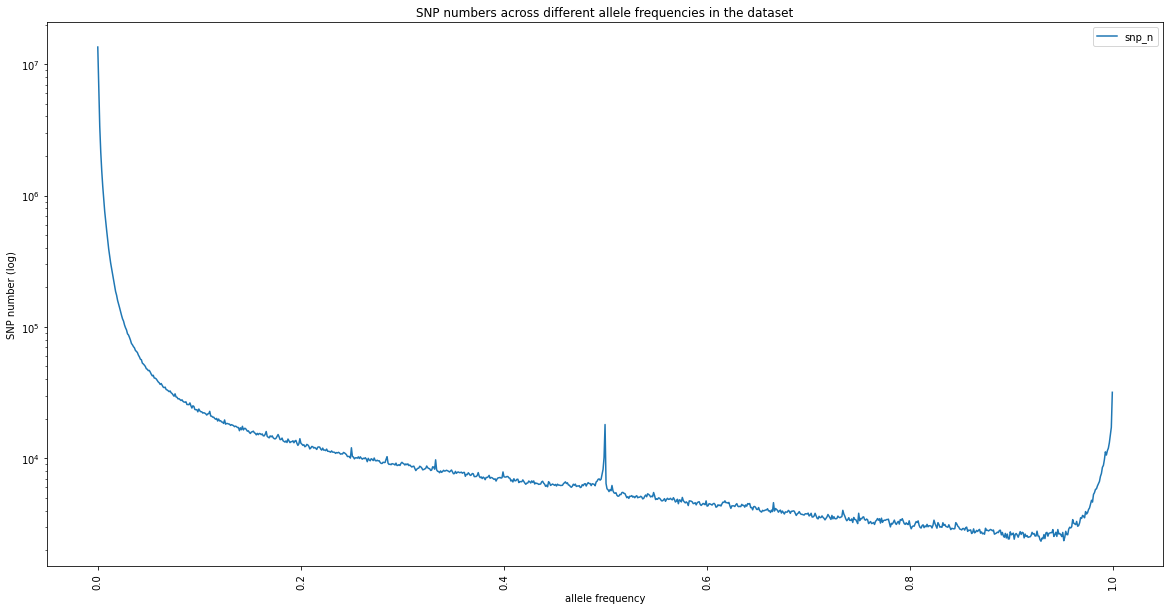

In [4]:
# SNP count frequency spectrum.
plt.rcParams["figure.figsize"] = (20,10)
freq_df.plot(x='index', y='snp_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('allele frequency')
plt.ylabel('SNP number (log)')
plt.title('SNP numbers across different allele frequencies in the dataset')

Text(0.5, 1.0, 'Indel numbers across different allele frequencies in the dataset')

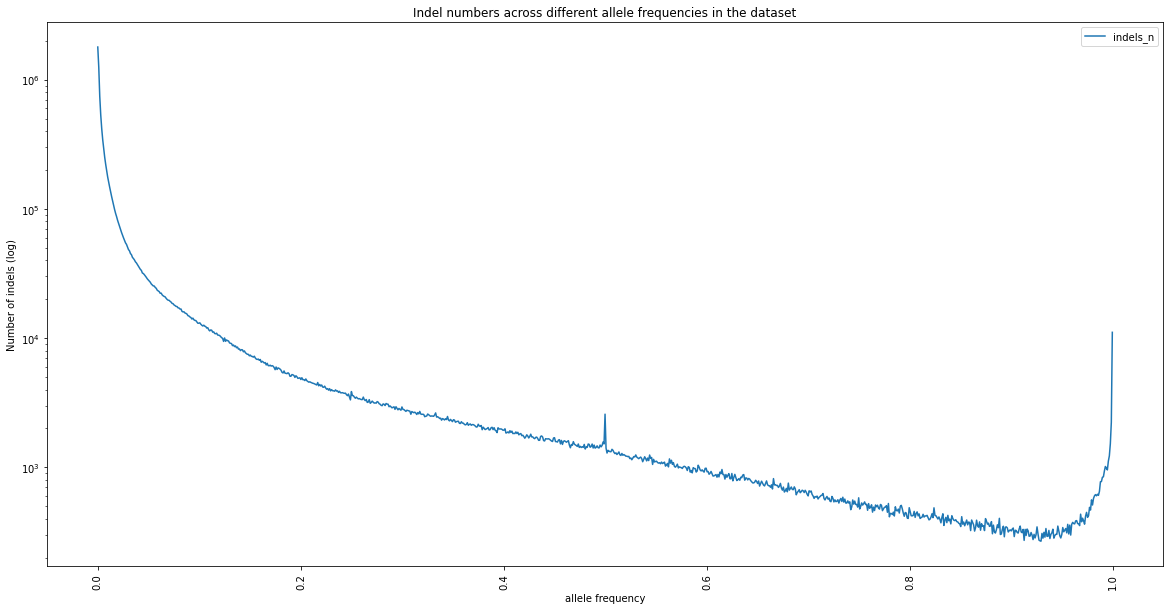

In [5]:
# INDEL count frequency spectrum.

plt.rcParams["figure.figsize"] = (20,10)
freq_df.plot(x='index', y='indels_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('allele frequency')
plt.ylabel('Number of indels (log)')
plt.title('Indel numbers across different allele frequencies in the dataset')


The QUAL value reflects how confident we are that a site displays some kind of variation considering 
the amount of data available (=depth of coverage at the site) (because we are more confident when we
have more observations to rely on), the quality of the mapping of the reads and alignment of the bases 
(because if we are not sure the bases observed really belong there, they do not contribute much to our 
confidence), and the quality of the base calls (because if they look like machine errors, they also do 
not contribute much to our confidence).


In [6]:
### 3. Stats by quality

# QUAL [2]id [3]Quality [4]number of SNPs [5]number of transitions (1st ALT) [6]number of transversions (1st ALT) [7]number of indels

# Read in the data.
quality_freq_data = {}
with open(vchk_file_path, 'r') as f:
    for line in f:
        
        # Divide the line into appropriate values.
        if line.startswith('QUAL'):
            line = line.split('\t')
            qual, snp_n, transitions_n, transversions_n, indels_n = float(line[2]), int(line[3]), int(line[4]), int(line[5]), int(line[6])
            quality_freq_data[qual] = [snp_n, transitions_n, transversions_n, indels_n]
            
# Make a dataframe
cols = ['snp_n', 'transitions_n', 'transversions_n', 'indels_n']
qual_df = pd.DataFrame.from_dict(quality_freq_data, orient='index', columns=cols)
qual_df = qual_df.reset_index()
qual_df.head()   # Check the first 5 rows of the df.

,index,snp_n,transitions_n,transversions_n,indels_n
0,30.0,36231,17807,18424,4935
1,31.0,25912,12039,13873,2493
2,32.0,24179,10984,13195,2613
3,33.0,40117,20096,20021,5322
4,34.0,31342,14248,17094,2494


Text(0.5, 1.0, 'SNP numbers across different qualities in the dataset')

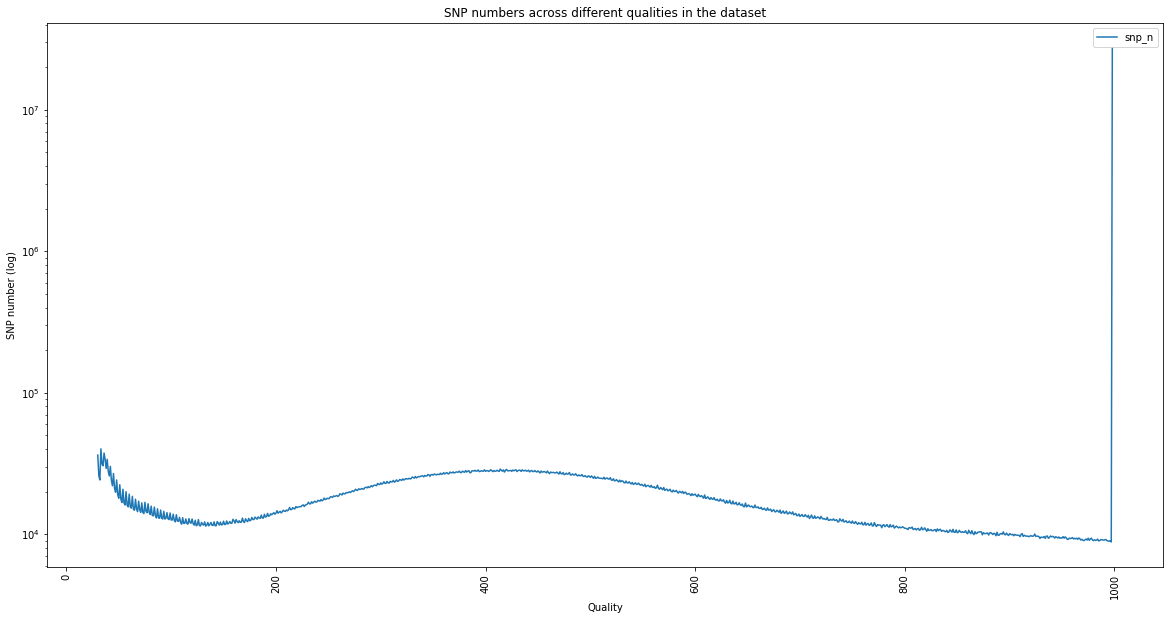

In [7]:
# SNP count at each quality
plt.rcParams["figure.figsize"] = (20,10)
qual_df.plot(x='index', y='snp_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Quality')
plt.ylabel('SNP number (log)')
plt.title('SNP numbers across different qualities in the dataset')

Text(0.5, 1.0, 'SNP numbers across different qualities in the dataset (Zoom in)')

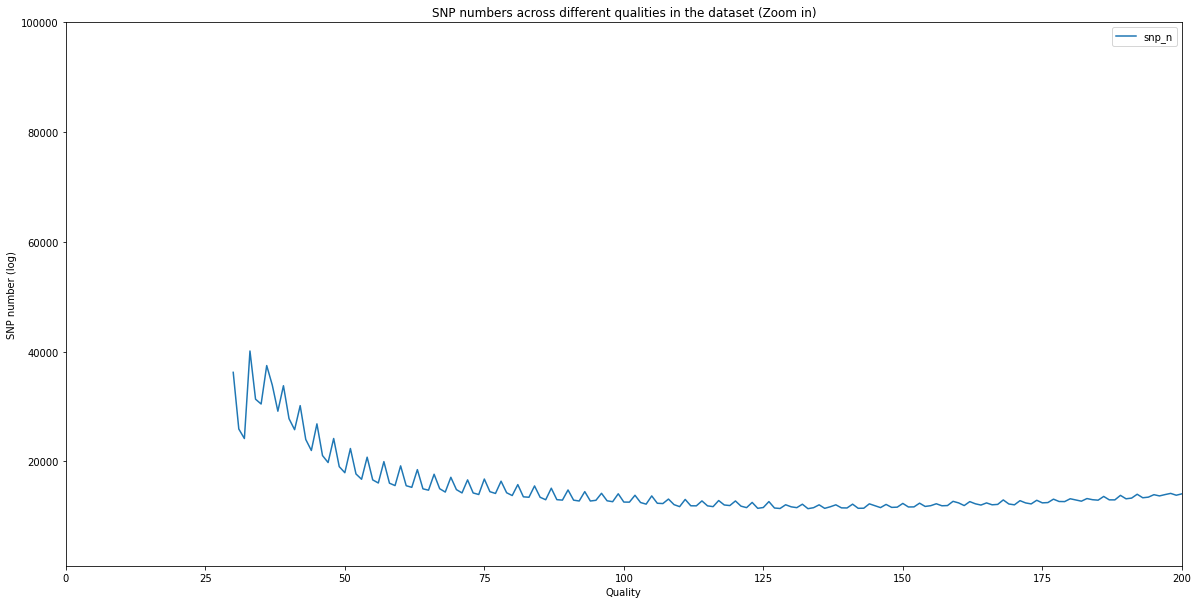

In [17]:
# Zoom in on the smaller values of the Quality score. Check how that distribution looks like in more detail.
plt.rcParams["figure.figsize"] = (20,10)
qual_df.plot(x='index', y='snp_n')
plt.xlim([0,200])
plt.ylim([1000, 100000])
plt.xlabel('Quality')
plt.ylabel('SNP number (log)')
plt.title('SNP numbers across different qualities in the dataset (Zoom in)')

Text(0.5, 1.0, 'Indel numbers across different qualities in the dataset')

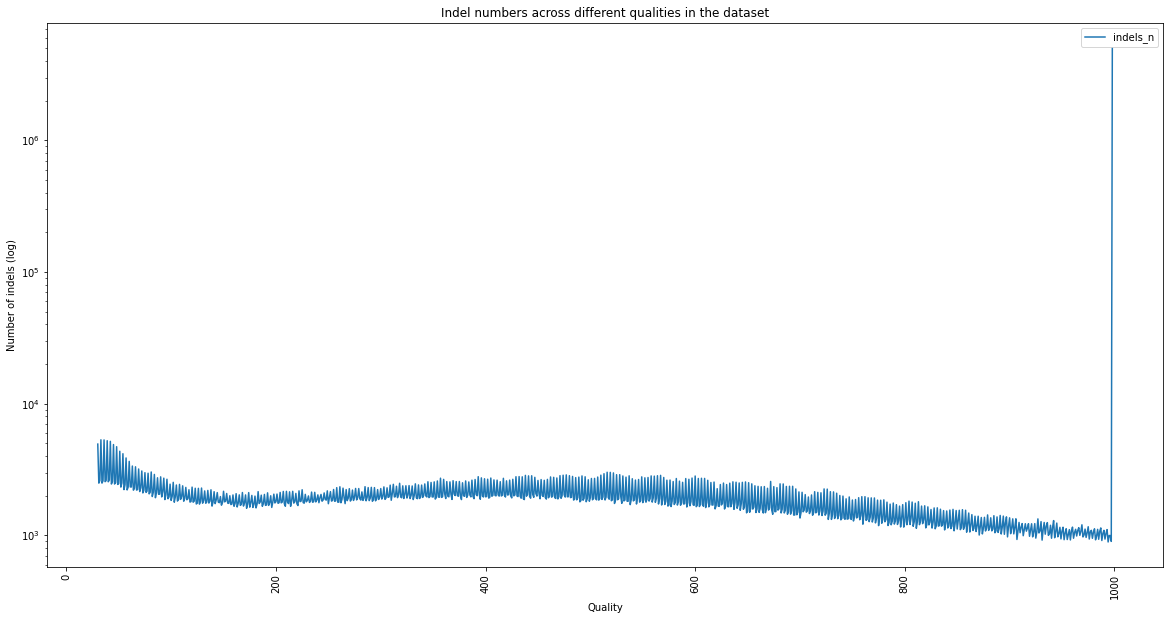

In [14]:
# Check the number of indels for each Quality score
plt.rcParams["figure.figsize"] = (20,10)
qual_df.plot(x='index', y='indels_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Quality')
plt.ylabel('Number of indels (log)')
plt.title('Indel numbers across different qualities in the dataset')

Text(0.5, 1.0, 'Indel numbers across different qualities in the dataset (Zoom in)')

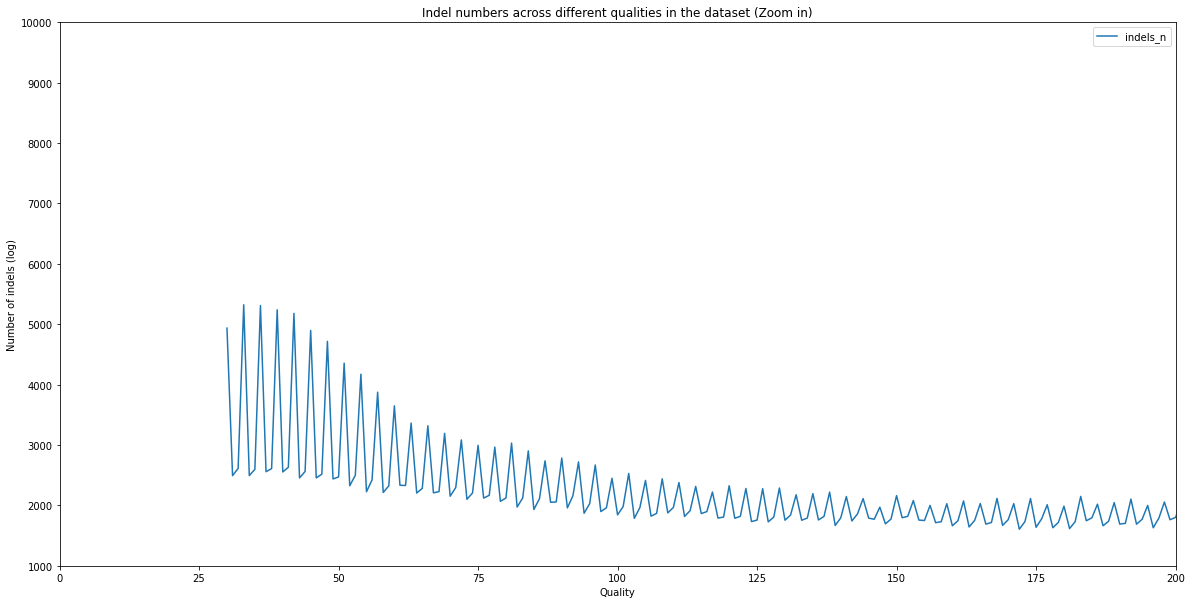

In [18]:
# Again, zoom in on the smaller values of the Quality score. Check how that distribution looks like in more detail.
plt.rcParams["figure.figsize"] = (20,10)
qual_df.plot(x='index', y='indels_n')
plt.xlim([0,200])
plt.ylim([1000, 10000])
plt.xlabel('Quality')
plt.ylabel('Number of indels (log)')
plt.title('Indel numbers across different qualities in the dataset (Zoom in)')

Text(0.5, 1.0, 'Indel numbers across different Indel lengths in the dataset')

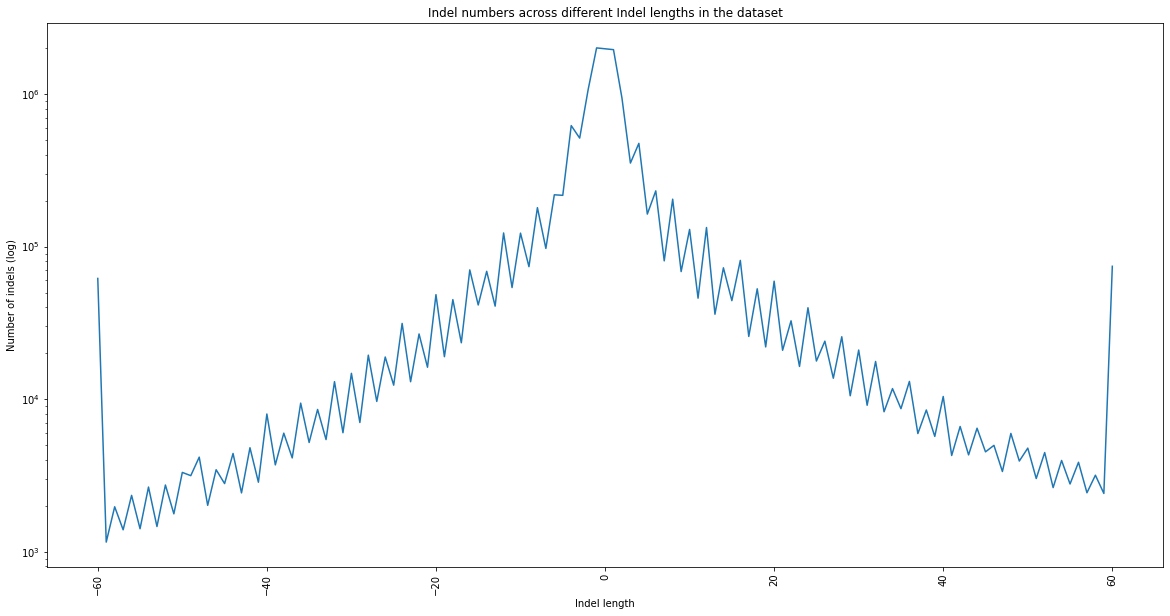

In [19]:
### 4. Indel distribution

# Length of the indels can be positive (insertions) or negative (deletions) (in  bp?)
# IDD [2]id [3]length  [4]count

# Open the file and extract the relevant data.
indel_freq_data = {}
with open(vchk_file_path, 'r') as f:
    for line in f:
        if line.startswith('IDD'):
            line = line.split('\t')
            length, count= float(line[2]), int(line[3])
            indel_freq_data[length] = count

# Plot the Indel frequency per length
lengths = list(indel_freq_data.keys())
counts = list(indel_freq_data.values())
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(lengths, counts)
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Indel length')
plt.ylabel('Number of indels (log)')
plt.title('Indel numbers across different Indel lengths in the dataset')      

In [20]:
### 5. Depth distribution
# DP [2]id [3]bin [4]number of genotypes [5]fraction of genotypes (%) [6]number of sites [7]fraction of sites (%)
# In this particular dataset, 2, 4,  and 5 don't have any info (all 0s).

# Open the file and extract the relavnt data
depth_freq_data = {}
with open(vchk_file_path, 'r') as f:
    for line in f:
        if line.startswith('DP'):
            line = line.split('\t')
            
            # In this case, the vchk has a field ">500" which is not a proper number. So we just put it as
            # depth = 501.
            if line[2] == '>500':
                depth, site_n, fraction = 501, int(line[5]), float(line[6])
            else:
                depth, site_n, fraction = int(line[2]), int(line[5]), float(line[6])
            depth_freq_data[depth] = [site_n, fraction]

# Make a dataframe
cols = ['site_n', 'fraction']
depth_df = pd.DataFrame.from_dict(depth_freq_data, orient='index', columns=cols)
depth_df = depth_df.reset_index()
depth_df.head()


,index,site_n,fraction
0,1,1,0.000002
1,2,191,0.000378
2,3,196,0.000388
3,4,312,0.000618
4,5,321,0.000636


Text(0.5, 1.0, 'Number of sites across different depths in the dataset')

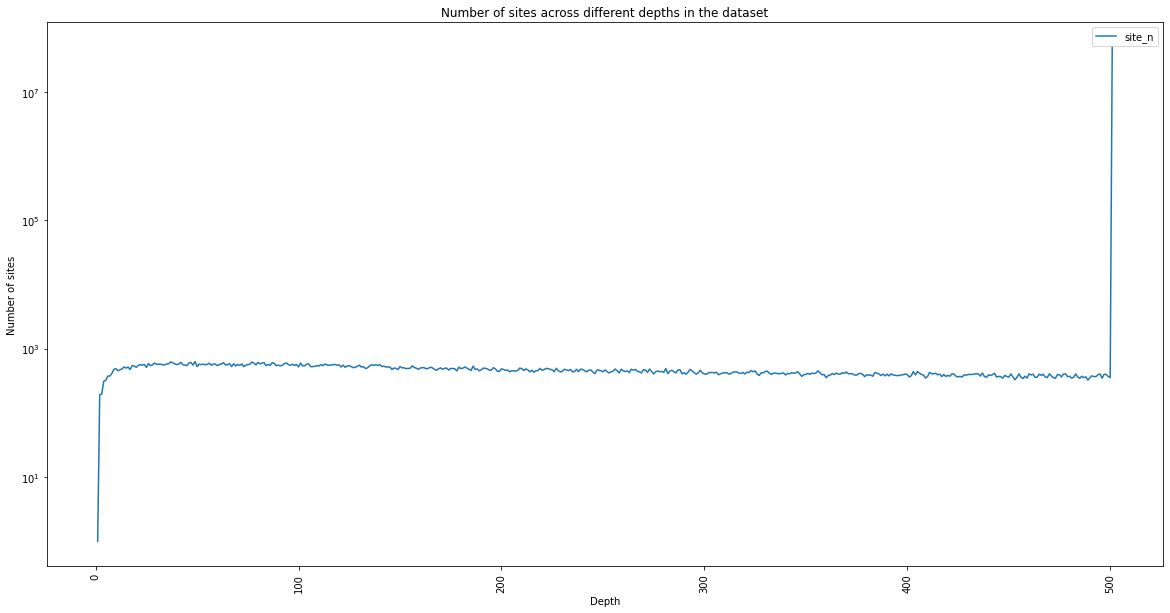

In [21]:
# Plot the depth frequency spectrum.
plt.rcParams["figure.figsize"] = (20,10)
depth_df.plot(x='index', y='site_n')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel('Depth')
plt.ylabel('Number of sites')
plt.title('Number of sites across different depths in the dataset')

Text(0.5, 1.0, 'Number of sites across different depths in the dataset (Zoom in)')

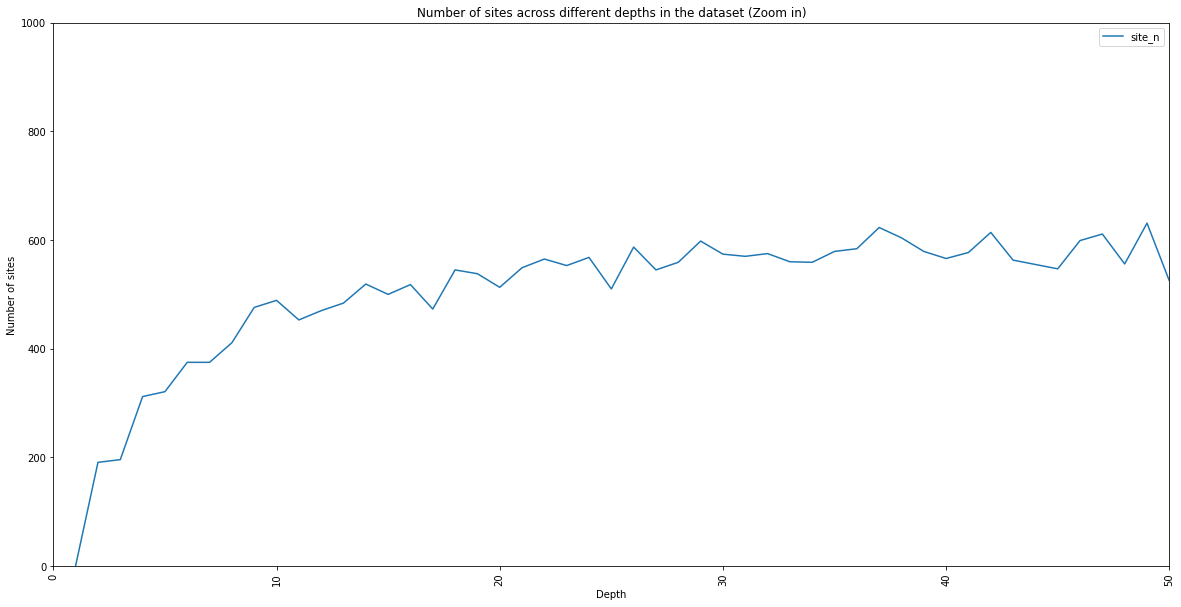

In [24]:
# Let's again zoom in on the sites with small depth values.
plt.rcParams["figure.figsize"] = (20,10)
depth_df.plot(x='index', y='site_n')
plt.xticks(rotation=90)
plt.xlim([0,50])
plt.ylim([0, 1000])
plt.xlabel('Depth')
plt.ylabel('Number of sites')
plt.title('Number of sites across different depths in the dataset (Zoom in)')

Next, we look at the information stored in the .FILTER.summary file. This file generates a summary of the number of SNPs and Ts/Tv ratio for each FILTER category.

The in-depth overview of the filtering can be found at: gatk.broadinstitute.org/hc/en-us/articles/360035531612-Variant-Quality-Score-Recalibration-VQSR- 

In summary, Varian Quality Score Recalibration (VQSR) is an algorithm that uses a Guassian mixture model to classify variants based on how their annotation values cluster against a training set of high-confidence variants. 
Based on that, it assigns a new score that describes how likely this variant is a true variant.  

Ts/Tv ratio is another quality measurement that is calculated by counting the number of transitions and transvertions. Higher ratio corresponds to good quality SNPs (while sequencing errors and false positive variants tend to have a Ts/Tv ratio closer to 1.0)

More info on that can be found at: Wang, J.; Raskin, L.; Samuels, D.C.; Shyr, Y.; Guo, Y. Genome measures used for quality control are dependent on gene function and ancestry. Bioinformatics 2015, 31, 318–323. 

In [24]:
# Use the .PRE-QC.FILTER.summary file to check the general description of the filters

filter_file_path = os.path.join(os.path.dirname(notebook_path), "data/" + name + ".PRE-QC.FILTER.summary")

columns=['N_VARIANTS', 'N_Ts','N_Tv','Ts/Tv']
filter_dict = {}
with open(filter_file_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        f, n_var, n_ts, n_tv, ts_tv = line.strip().split('\t')
        filter_dict[f] = [int(n_var), int(n_ts), int(n_tv), float(ts_tv)]
        
filter_df = pd.DataFrame.from_dict(filter_dict, orient='index', columns=columns)
#depth_df = depth_df.reset_index()
filter_df.head()

,N_VARIANTS,N_Ts,N_Tv,Ts/Tv
PASS,39871929,23294994,10943368,2.128690
VQSRTrancheSNP99.00to99.90,4836193,2970366,1865827,1.591980
VQSRTrancheSNP99.90to100.00,4529661,2194277,2335384,0.939579
VQSRTrancheINDEL99.00to99.90,959507,15015,12966,1.158030
VQSRTrancheINDEL99.90to100.00,294798,4118,4680,0.879915


In [25]:
# Check the mean depth per chromosome using ldepth.mean file
# Does each chromosome have similar mean depth or is there a variation? 
# Are there regions in each chromosomes that have smaller mean depth than other?


notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
depth_file_path = os.path.join(os.path.dirname(notebook_path), "data/" + name + ".PRE-QC.ldepth.mean")

# Read the mean depth file and divide the info into chromosomes.
per_chr_depth = {}
with open(depth_file_path, 'r') as f:
    f.readline()  # skip header
    for line in f:
        ch, depth = line.split('\t')[0][3:], float(line.split('\t')[2])
        if ch not in per_chr_depth.keys():
            print(ch)
            per_chr_depth[ch] = [depth]
        else:
            per_chr_depth[ch].append(depth)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
X
Y


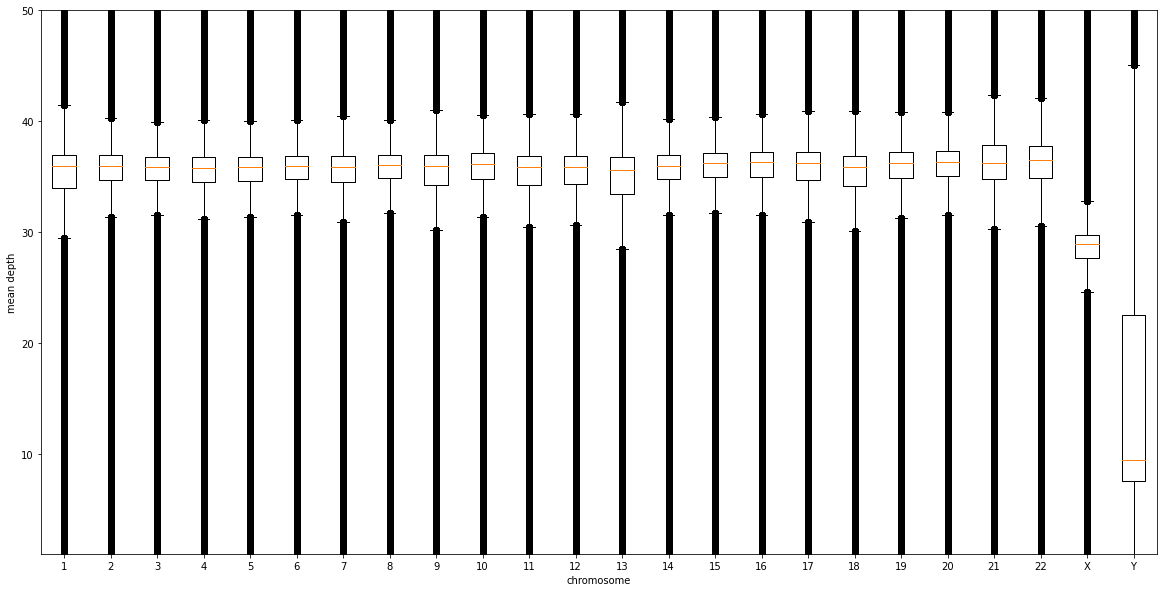

In [26]:
# Plot a box plot of the mean depths per chromosome. Focus on the lower values of the mean depth in order to 
# figure out which depth we want to keep during the more stringent QC. 

labels, data = [*zip(*per_chr_depth.items())]  # 'transpose' items to parallel key, value lists

plt.rcParams["figure.figsize"] = (20,10)
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.ylim([1, 50])
plt.xlabel('chromosome')
plt.ylabel('mean depth')
plt.show()

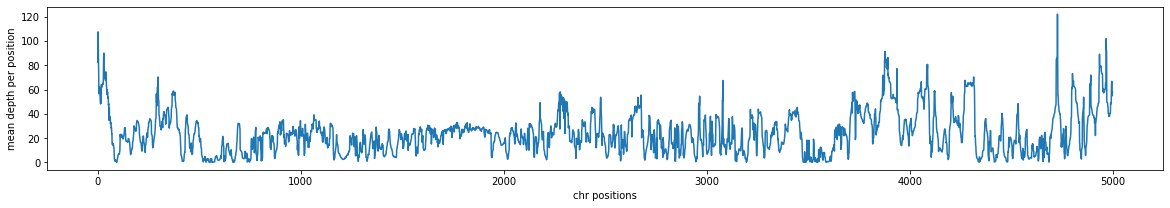

In [27]:
# What is the mean depth for the consecutive positions in the chromosome?

dist_range = [0,5000] # position range we want to plot (start, end)

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(dist_range[0],dist_range[1]), per_chr_depth['1'][dist_range[0]:dist_range[1]])
plt.ylabel('mean depth per position')
plt.xlabel('chr positions')
plt.show()


In [29]:
# How many individuals are there in the dataset? How does the mean depth look like per individual?
notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_depth_file_path = os.path.join(os.path.dirname(notebook_path), "data/" + name + ".PRE-QC.idepth")

indiv_mean_depth = {}

# Read the idepth file and extract the IDs and mean depths
with open(indiv_depth_file_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        line = line.split('\t')
        indiv_mean_depth[line[0]] = float(line[2])

In [30]:
print('There are ' + str(len(indiv_mean_depth.keys())) + ' individuals in the ' + name + '.hg38 TANGL dataset')
#pprint(list(indiv_mean_depth.keys()))

There are 1025 individuals in the joint_colombia_annotated.hg38 TANGL dataset


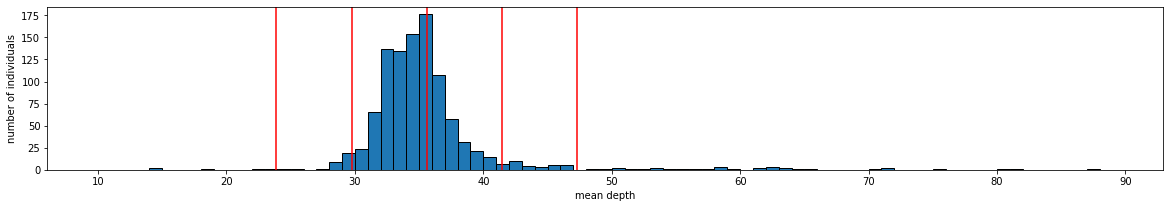

In [39]:
# Make a histogram of individuals and the depth sites
all_fractions = list(indiv_mean_depth.values())

# Calculate the mean and standard deviations
mean = np.mean(all_fractions)
std = np.std(all_fractions)


r = range(10, 90, 1)
plt.hist(all_fractions, bins=r, edgecolor='black')

plt.axvline(x=mean, ymin=0, ymax=175, c='r')   # plot mean line
plt.axvline(x=mean+std, ymin=0, ymax=175, c='r')  # plot right std line
plt.axvline(x=mean-std, ymin=0, ymax=175, c='r')  # plot left std line
plt.axvline(x=mean+(std*2), ymin=0, ymax=175, c='r')  # plot right 2 std line
plt.axvline(x=mean-(std*2), ymin=0, ymax=175, c='r')  # plot left 2 std line

plt.xlabel('mean depth')
plt.ylabel('number of individuals')
plt.show()

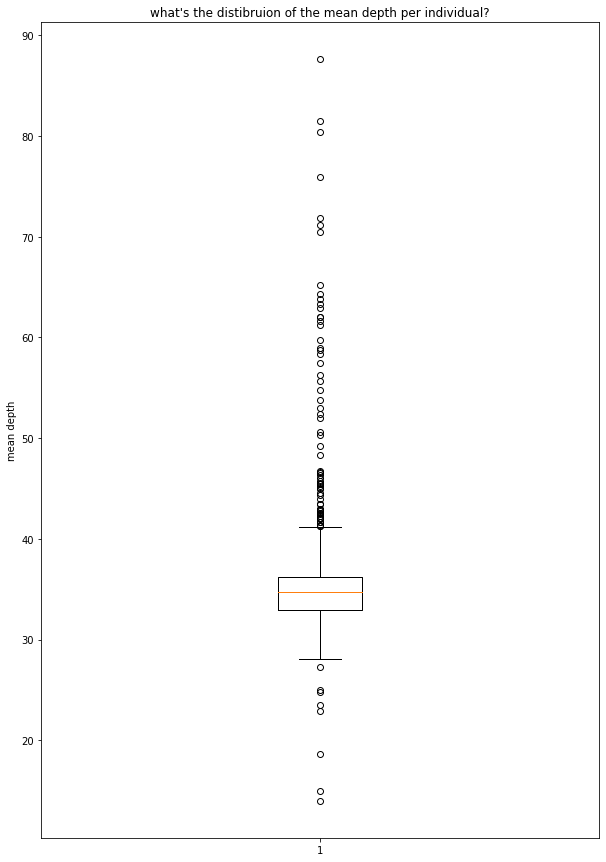

In [41]:
# How does the mean depth look like per individual?

plt.rcParams["figure.figsize"] = (10,15)
plt.boxplot(indiv_mean_depth.values())
plt.title('what\'s the distibruion of the mean depth per individual?')
plt.ylabel('mean depth')
plt.show()

In [42]:
# How much data is missing per site? 
# Given a site and missingness for all individuals, what's the average for each chr?
# What's the distribution of missingness?

notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_depth_file_path = os.path.join(os.path.dirname(notebook_path), 'data/' + name + '.PRE-QC.lmiss')

miss_per_chr = {}

# Read the idepth file and extract the IDs and missingness
with open(indiv_depth_file_path, 'r') as f:
    f.readline()   # skip header (CHR, POS, N_DATA, N_GENOTYPE_FILTERED, N_MISS, F_MISS)
    for line in f:
        line = line.split('\t')
        chr, n_miss = line[0][3:], int(line[4])
        if chr not in miss_per_chr.keys():
            print(chr)
            miss_per_chr[chr] = [n_miss]
        else:
            miss_per_chr[chr].append(n_miss)
            

        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
X
Y


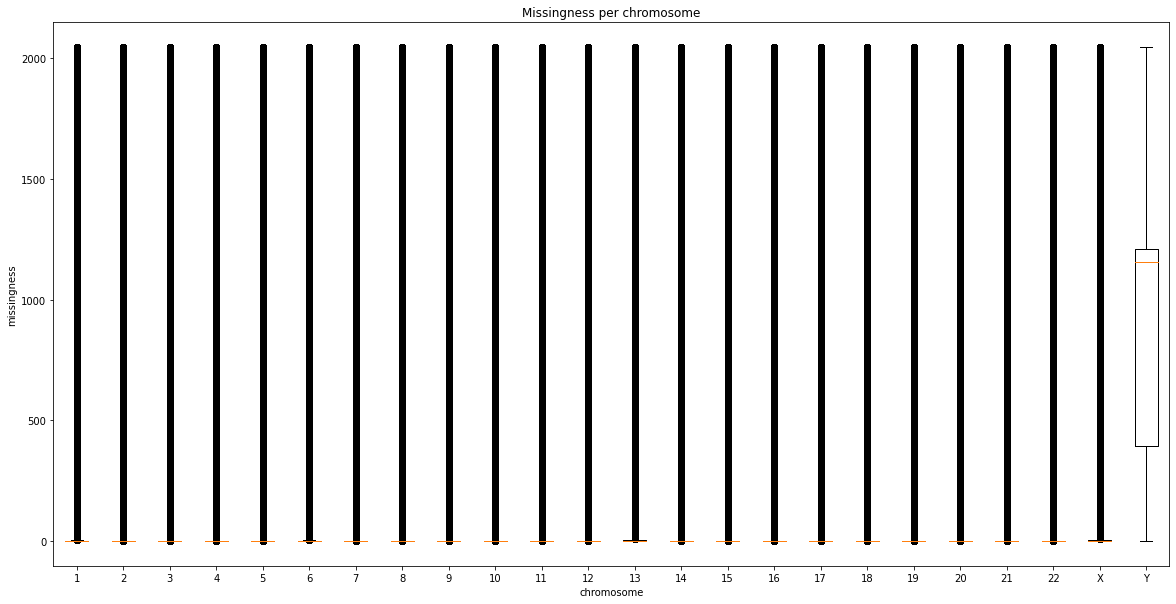

In [52]:
# Plot the mean missingness of each chromosome 

labels, data = [*zip(*miss_per_chr.items())]  # 'transpose' items to parallel key, value lists

plt.rcParams["figure.figsize"] = (20,10)
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)

plt.title('Missingness per chromosome')
plt.xlabel('chromosome')
plt.ylabel('missingness')
plt.show()


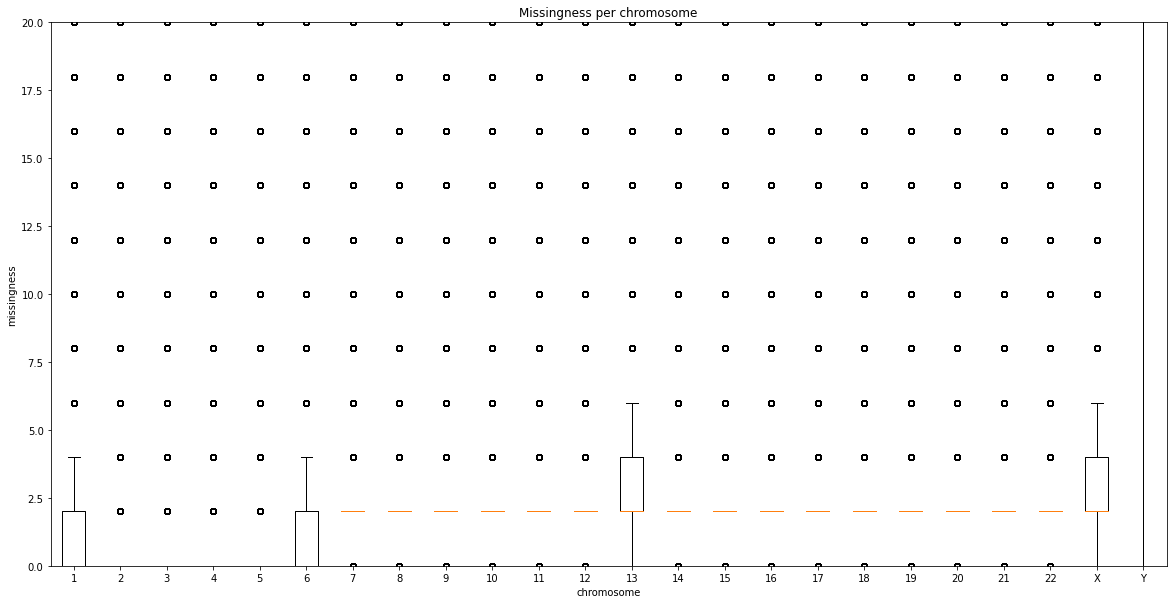

In [53]:
# Plot the mean missingness of each chromosome 
# Zoom in on the bottom of the graph

labels, data = [*zip(*miss_per_chr.items())]  # 'transpose' items to parallel key, value lists

plt.rcParams["figure.figsize"] = (20,10)
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.ylim([0, 20])

plt.title('Missingness per chromosome')
plt.xlabel('chromosome')
plt.ylabel('missingness')
plt.show()

In [3]:
# What about the missingness per individual? How much sites does each individual missing?

name = 'joint_colombia_annotated'
notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_miss_file_path = os.path.join(os.path.dirname(notebook_path), 'data/' + name + ".PRE-QC.imiss")

indiv_missingness = {}
indiv_missingness_f = {}

# Read the imiss file and extract the IDs and N_MISS
with open(indiv_miss_file_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        line = line.split('\t')
        indiv_missingness[line[0]] = int(line[3])
        indiv_missingness_f[line[0]] = float(line[4])

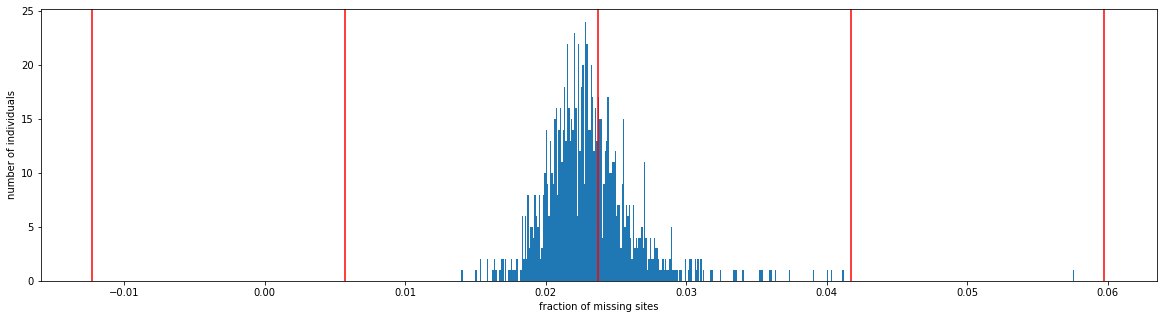

In [4]:
# Make a histogram of individuals and the fraction of missing sites
all_fractions = list(indiv_missingness_f.values())

# Calculate the mean and standard deviations
mean = np.mean(all_fractions)
std = np.std(all_fractions)

plt.rcParams["figure.figsize"] = (20,5)
r = np.arange(0.01, 0.06, 0.0001)
plt.hist(all_fractions, bins=r)

plt.axvline(x=mean, ymin=0, ymax=175, c='r')   # plot mean line
plt.axvline(x=mean+std, ymin=0, ymax=175, c='r')  # plot right std line
plt.axvline(x=mean-std, ymin=0, ymax=175, c='r')  # plot left std line
plt.axvline(x=mean+(std*2), ymin=0, ymax=175, c='r')  # plot right 2 std line
plt.axvline(x=mean-(std*2), ymin=0, ymax=175, c='r')  # plot left 2 std line

plt.xlabel('fraction of missing sites')
plt.ylabel('number of individuals')
plt.show()

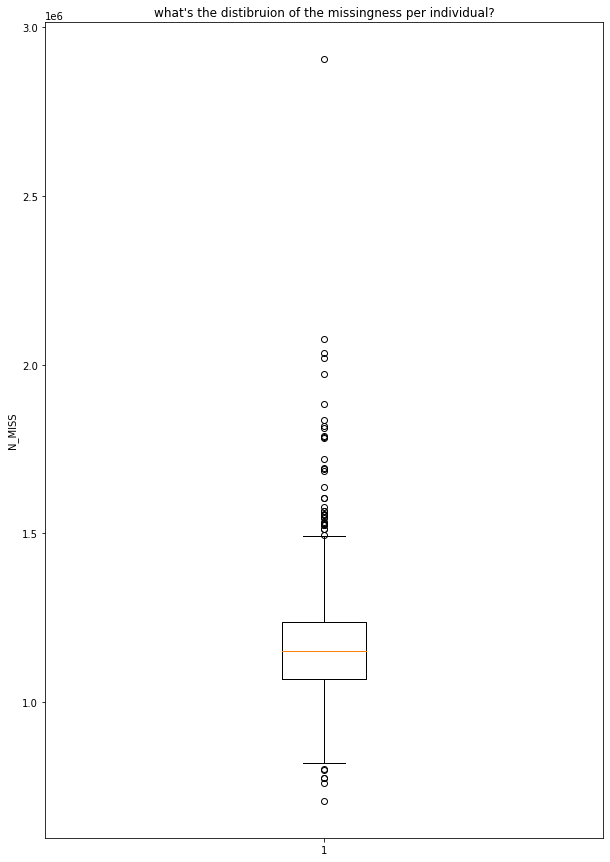

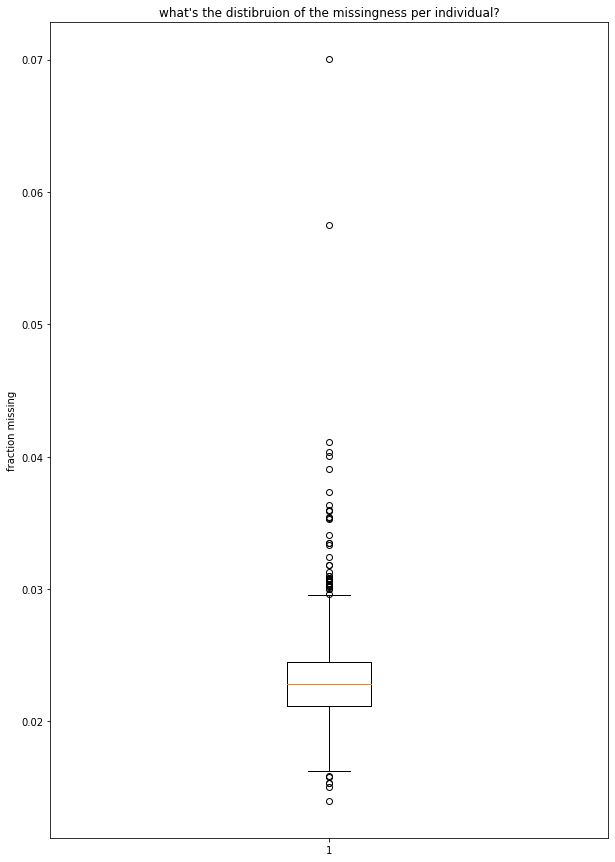

In [59]:
# How does the mean depth look like per individual?
plt.rcParams["figure.figsize"] = (10,15)

# Get rid of an outlier (~3 MB)
indiv_missingness_vals = np.array(list(indiv_missingness.values()))
indiv_missingness_vals = [i for i in indiv_missingness_vals if i < 3000000]

plt.boxplot(indiv_missingness_vals)
plt.title('what\'s the distibruion of the missingness per individual?')
plt.ylabel('N_MISS')
plt.show()

# Get rid of the outlier at ~60%
indiv_missingness_fractions = np.array(list(indiv_missingness_f.values()))
indiv_missingness_fractions = [i for i in indiv_missingness_fractions if i < 0.58]

# Same thing but with the fractions instead of full numbers
plt.boxplot(indiv_missingness_fractions)
plt.title('what\'s the distibruion of the missingness per individual?')
plt.ylabel('fraction missing')
plt.show()

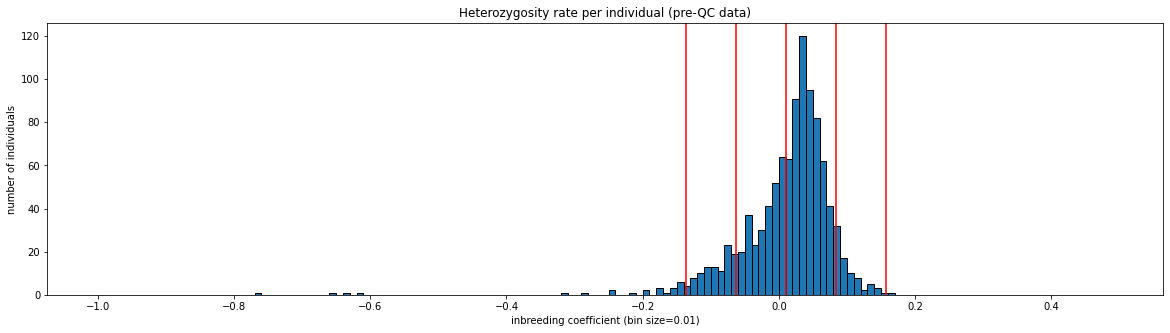

In [6]:
# Look at the measure of heterozygosity, the inbreeding coefficient (F)
name = 'joint_colombia_annotated'
notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_het_path = os.path.join(os.path.dirname(notebook_path), "data/" + name + ".PRE-QC.het")

f_list = []
with open(indiv_het_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        indiv, f_coeff = line.split('\t')[0], float(line.strip().split('\t')[-1])
        f_list.append(f_coeff)
        
# Calculate the mean and standard deviations
mean = np.mean(f_list)
std = np.std(f_list)

plt.rcParams["figure.figsize"] = (20,5)
r = np.arange(-1,0.5, 0.01)
plt.hist(f_list, bins=r, edgecolor='black')

plt.axvline(x=mean, ymin=0, ymax=175, c='r')   # plot mean line
plt.axvline(x=mean+std, ymin=0, ymax=175, c='r')  # plot right std line
plt.axvline(x=mean-std, ymin=0, ymax=175, c='r')  # plot left std line
plt.axvline(x=mean+(std*2), ymin=0, ymax=175, c='r')  # plot right 2 std line
plt.axvline(x=mean-(std*2), ymin=0, ymax=175, c='r')  # plot left 2 std line

plt.xlabel('inbreeding coefficient (bin size=0.01)')
plt.ylabel('number of individuals')
plt.title('Heterozygosity rate per individual (pre-QC data)')
plt.show()


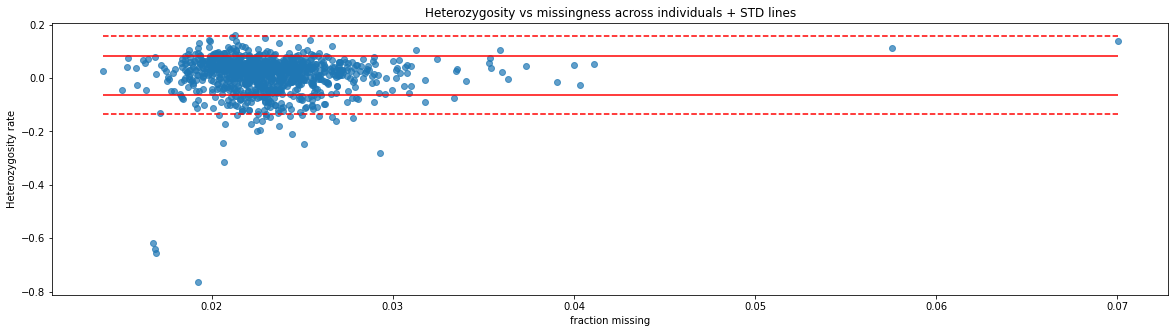

In [27]:
# Check the missingness vs heterozygosity rate per individual

name = 'joint_colombia_annotated'
notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_miss_file_path = os.path.join(os.path.dirname(notebook_path), 'data/' + name + ".PRE-QC.imiss")

indiv_missingness = {}

# Read the imiss file and extract the IDs and N_MISS
with open(indiv_miss_file_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        line = line.split('\t')
        if line[0] != 'HALB3015251':  # Get rid of the outlier
            indiv_missingness[line[0]] = float(line[4])
        
        
indiv_het_path = os.path.join(os.path.dirname(notebook_path), "data/" + name + ".PRE-QC.het")

indiv_heterozygosity = {}

with open(indiv_het_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        indiv, f_coeff = line.split('\t')[0], float(line.strip().split('\t')[-1])
        if indiv != 'HALB3015251':
            indiv_heterozygosity[indiv] = f_coeff
        
        
# Plot missingness vs heterozygosity (the individuals should be the same in both files)
individuals = list(indiv_missingness.keys())
missingness, f_coeff = [indiv_missingness[i] for i in individuals], [indiv_heterozygosity[i] for i in individuals]

# Calculate the mean and standard deviations for the heterozygosity
mean = np.mean(f_coeff)
std = np.std(f_coeff)

plt.rcParams["figure.figsize"] = (20,5)
plt.scatter(missingness, f_coeff, alpha=0.5)

#plt.hlines(y=mean, xmin=min(missingness), xmax=max(missingness), colors='r')   # plot mean line
plt.hlines(y=mean+std, xmin=min(missingness), xmax=max(missingness), colors='r')  # plot right std line
plt.hlines(y=mean-std, xmin=min(missingness), xmax=max(missingness), colors='r')  # plot left std line
plt.hlines(y=mean+(std*2), xmin=min(missingness), xmax=max(missingness), colors='r', linestyles='--') # plot right 2 std line
plt.hlines(y=mean-(std*2), xmin=min(missingness), xmax=max(missingness), colors='r', linestyles='--') # plot left 2 std line

plt.title('Heterozygosity vs missingness across individuals + STD lines')
plt.ylabel('Heterozygosity rate')
plt.xlabel('fraction missing')
plt.show()

